#Preparing Data

In [ ]:
from tensorflow.keras.utils import plot_model
import tensorflow

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.applications.densenet import DenseNet121
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel

extracting a ZIP file containing a dataset into a specified directory

In [ ]:
import zipfile
import os
zip_file_path = 'C://Users//Sanjay//Downloads//Myntra.zip'
extracted_path = 'C://Users//Sanjay//Downloads//Myntra'

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# List content of extracted dataset
dirs_names = os.listdir(extracted_path)


In [ ]:
dirs_names

['images', 'Myntra.csv', 'styles.csv']

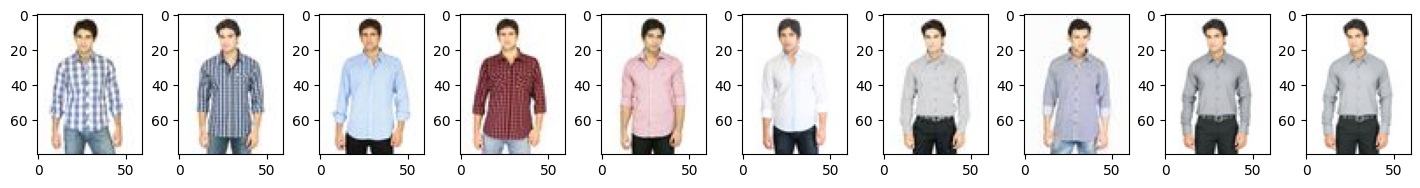

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(20, 30):
    plt.subplot(6, 10, i - 20 + 1)
    cloth_img = mpimg.imread(os.path.join(extracted_path, 'images', '200' + str(i) + '.jpg'))  # Construct the correct file path
    plt.imshow(cloth_img)
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

In [ ]:
pip install fsspec

   ---------------------------------------- 0.0/172.0 kB ? eta -:--:--
   ---------------- ----------------------- 71.7/172.0 kB 1.3 MB/s eta 0:00:01
   ---------------------------- ----------- 122.9/172.0 kB 1.2 MB/s eta 0:00:01
   -------------------------------------- - 163.8/172.0 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 172.0/172.0 kB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
styles_df = pd.read_csv(extracted_path + "/styles.csv", nrows=6000)
styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1) # Make image column contains (id.jpg)
print(styles_df.shape)
styles_df.head(5)

(6000, 11)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


##Visualizing  the distribution of the top 10 article types in the dataset

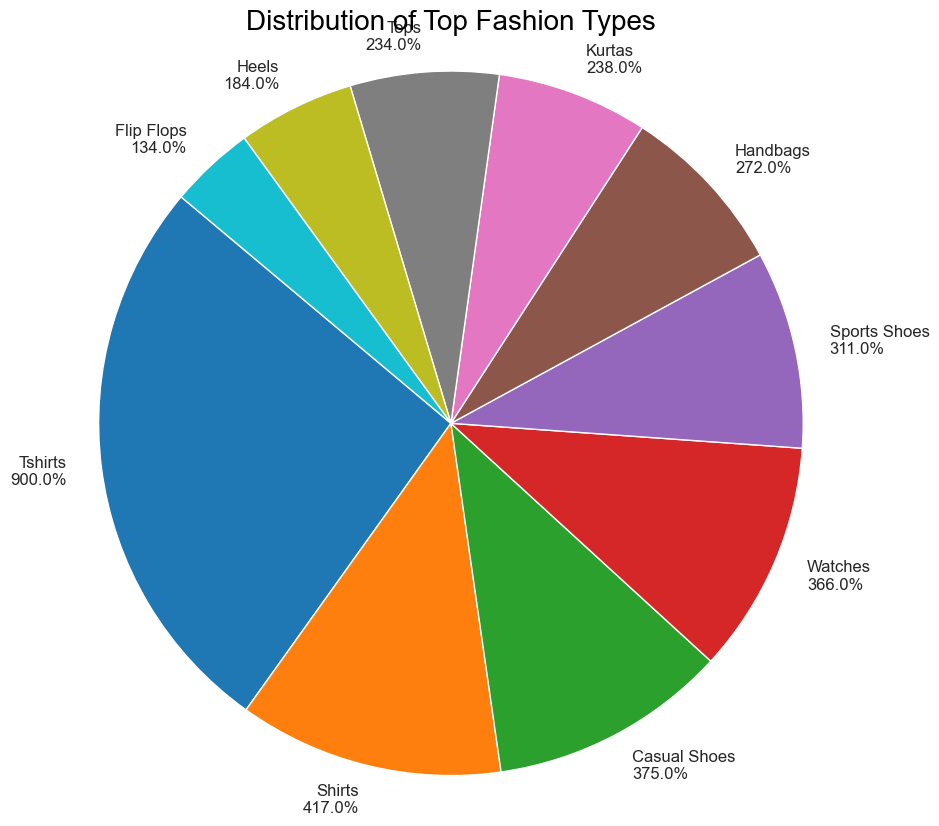

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

article_type_counts = styles_df['articleType'].value_counts()
top_n = 10
top_article_type_counts = article_type_counts.head(top_n)

plt.figure(figsize=(10,10))
plt.title('Distribution of Top Fashion Types', fontsize=20)
sns.set_palette("rainbow")
sns.set_style("whitegrid")
plt.pie(top_article_type_counts, labels=top_article_type_counts.index + '\n' + top_article_type_counts.map('{:.1f}%'.format), autopct='', startangle=140, textprops={'fontsize': 12})
plt.axis('equal')

plt.show()


##Data Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


img_width, img_height = 100, 100

rescale = 1./255

datagen = ImageDataGenerator(
    rescale=rescale,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    directory=extracted_path,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)


Found 44441 images belonging to 1 classes.


##VGG16 Model

In [ ]:
img_width, img_height, chnls = 100, 100, 3

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, chnls))
vgg16.trainable=False
vgg16_model = keras.Sequential([vgg16, GlobalMaxPooling2D()])
vgg16_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
def img_path(img):

    return extracted_path + '/images/' + img

def predict(model, img_name):


    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
#
    img = image.img_to_array(img)

    img = np.expand_dims(img, axis=0)

    img = preprocess_input(img)
    return model.predict(img)

In [ ]:
def get_embeddings(df, model):

    df_copy = df
    df_embeddings = df_copy['image'].apply(lambda x: predict(vgg16_model, x).reshape(-1))
    df_embeddings = df_embeddings.apply(pd.Series)
    return df_embeddings

df_embeddings = get_embeddings(styles_df, vgg16_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
df_embeddings.to_csv("C:\\Users\\Sanjay\\Downloads\\New folder\\df_embeddings.csv", index=False)

In [ ]:
df_embeddings.head(5)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.000000,0.0,0.000000,0.000000,0.416762,0.000000,0.000000,0.0,0.0,0.0,...,0.465505,2.526568,0.000000,0.000000,0.023388,0.256389,0.000000,0.000000,0.663360,2.707127
1,0.656389,0.0,0.226173,0.000000,0.734096,0.000000,1.910263,0.0,0.0,0.0,...,1.004094,3.999025,0.000000,0.623049,0.519439,0.552858,1.366484,0.992332,0.629039,1.477583
2,0.113616,0.0,0.000000,1.226544,0.866502,0.000000,0.938749,0.0,0.0,0.0,...,1.014141,0.170607,0.000000,0.115413,0.141611,0.493683,0.078028,0.000000,1.143075,0.000000
3,0.000000,0.0,0.000000,0.000000,0.614342,0.000000,0.848842,0.0,0.0,0.0,...,1.126509,2.467212,0.124418,0.000000,0.000000,0.192454,0.507867,0.000000,0.111598,2.579833
4,0.000000,0.0,0.000000,0.000000,0.096240,0.220482,0.000000,0.0,0.0,0.0,...,0.163552,0.334457,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044779,2.458951


In [ ]:
sample_image = predict(vgg16_model, '10439.jpg')
sample_image.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step


(1, 512)

##Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Assuming y_true contains the ground truth labels and y_pred contains the predicted labels
y_true = np.array([0, 1, 1, 0, 1])
y_pred = np.array([0, 1, 0, 0, 1])

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.8
Precision: 1.0
Recall: 0.6666666666666666
F1-score: 0.8


In [ ]:
df_sample_image = pd.DataFrame(sample_image)
print(df_sample_image)

        0    1         2    3         4         5         6    7    8    \
0  1.140345  0.0  0.579168  0.0  0.165408  0.584026  2.103538  0.0  0.0   

        9    ...       502       503  504  505  506       507  508       509  \
0  0.631097  ...  0.669483  3.072674  0.0  0.0  0.0  0.702801  0.0  1.009241   

        510       511  
0  0.381211  2.277205  

[1 rows x 512 columns]


In [ ]:
sample_similarity = linear_kernel(df_sample_image, df_embeddings)
print(sample_similarity)

[[471.53452 459.77975 355.30356 ... 360.2687  581.85547 399.1126 ]]


In [ ]:
def get_similarity(model):

    sample_image = predict(vgg16_model, '1.jpg')
    df_sample_image = pd.DataFrame(sample_image)
    sample_similarity = linear_kernel(df_sample_image, df_embeddings)
    return sample_similarity

In [ ]:
def normalize_sim(similarity):

    x_min = similarity.min(axis=1)
    x_max = similarity.max(axis=1)
    norm = (similarity-x_min)/(x_max-x_min)[:, np.newaxis]
    return norm

sample_similarity_norm = normalize_sim(sample_similarity)
sample_similarity_norm.shape

(1, 6000)

In [ ]:
def get_recommendations(df, similarity):

    sim_scores = list(enumerate(similarity[0]))


    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)


    sim_scores = sim_scores[0:5]
    print(sim_scores)

    cloth_indices = [i[0] for i in sim_scores]

    return df['image'].iloc[cloth_indices]

[(462, 1.0), (2951, 0.9824988), (5414, 0.94913775), (4312, 0.8940629), (83, 0.87399846)]


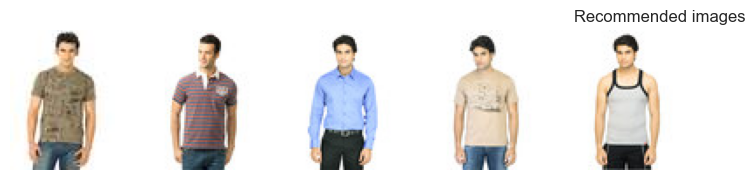

In [ ]:
recommendation = get_recommendations(styles_df, sample_similarity_norm)
recommendation_list = recommendation.to_list()

plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(extracted_path + '/images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("Recommended images",loc='left')
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

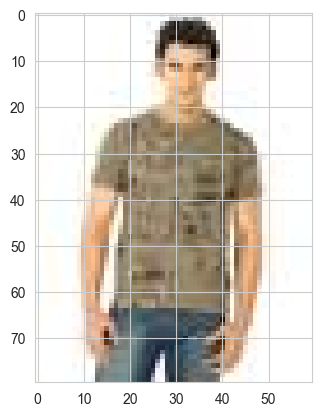

In [ ]:


url = "C:\\Users\\Sanjay\\Downloads\\Myntra\\images\\10439.jpg"
a = plt.imread(url)
plt.imshow(a)

##Fashion Recomendation system

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


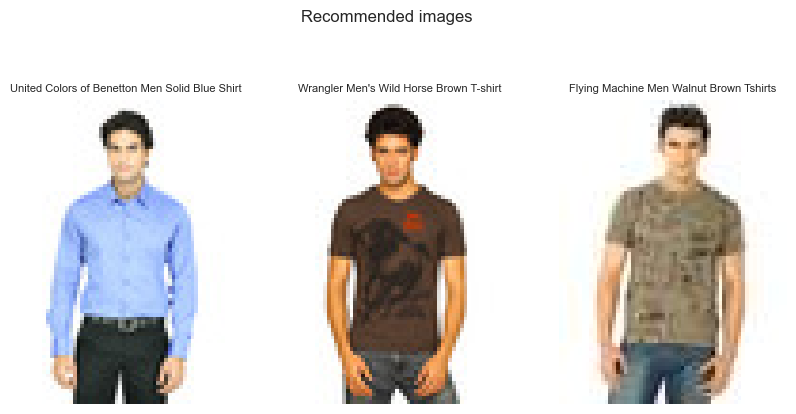

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[{'image': '19716.jpg', 'style_description': 'United Colors of Benetton Men Solid Blue Shirt'}, {'image': '3845.jpg', 'style_description': "Wrangler Men's Wild Horse Brown T-shirt"}, {'image': '10439.jpg', 'style_description': 'Flying Machine Men Walnut Brown Tshirts'}]


In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow.keras as keras
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalMaxPooling2D
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics.pairwise import linear_kernel

class fashion_recommendations:
    """ Production class for recommendations of fashion from similarity """

    def __init__(self, img_path, df_embeddings, styles_path):
        self.img_path = img_path
        self.df_embeddings = df_embeddings
        self.styles_path = styles_path
        self.descriptions = None


    def get_styles_df(self):
        """ Load a dataframe contains styles details and images """
        styles_df = pd.read_csv(self.styles_path, nrows=6000)
        styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1)
        return styles_df

    def load_model(self):
        """ Load our model """
        vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(100, 100, 3))
        vgg16.trainable=False
        vgg16_model = keras.Sequential([vgg16, GlobalMaxPooling2D()])
        return vgg16_model

    def predict(self, model, img_path):
        """ Load and preprocess image then make prediction """
        img = image.load_img(img_path, target_size=(100, 100))

        img = image.img_to_array(img)

        img = np.expand_dims(img, axis=0)

        img = preprocess_input(img)
        return model.predict(img)

    def get_similarity(self):
        """ Get similarity of custom image """
        model = self.load_model()
        df_embeddings = self.df_embeddings
        sample_image = self.predict(model, self.img_path)
        df_sample_image = pd.DataFrame(sample_image)
        sample_similarity = linear_kernel(df_sample_image, df_embeddings)
        return sample_similarity

    def normalize_sim(self):
        """ Normalize similarity results """
        similarity = self.get_similarity()
        x_min = similarity.min(axis=1)
        x_max = similarity.max(axis=1)
        norm = (similarity-x_min)/(x_max-x_min)[:, np.newaxis]
        return norm

    def get_recommendations(self):
        """ Get recommended images """
        similarity = self.normalize_sim()
        df = self.get_styles_df()

        sim_scores = list(enumerate(similarity[0]))

        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        cloth_indices = [i[0] for i in sim_scores[:3]]

        return df.iloc[cloth_indices]

    def print_recommendations(self):
        recommendations = self.get_recommendations()
        plt.figure(figsize=(10, 5))
        for j, (index, row) in enumerate(recommendations.iterrows()):
          plt.subplot(1, 3, j+1)
          cloth_img = mpimg.imread("C://Users//Sanjay//Downloads//Myntra//images//" + row['image'])
          plt.imshow(cloth_img)
          plt.title(row['productDisplayName'], fontsize=8)
          plt.axis("off")
        plt.suptitle("Recommended images", fontsize=12)
        plt.subplots_adjust(wspace=0.2)
        plt.show()


    def print_style_description(self):
        """ Print the style description of the recommended images"""
        recommendations = self.get_recommendations()
        descriptions = []
        for index, row in recommendations.iterrows():
            description = {
                'image': row['image'],
                'style_description': row['productDisplayName']
            }
            descriptions.append(description)
        self.descriptions = descriptions
        return descriptions


img_path = "C://Users//Sanjay//Downloads//Myntra//images//10439.jpg"
styles_path = "C://Users//Sanjay//Downloads//Myntra//styles.csv"
obj = fashion_recommendations(img_path, df_embeddings, styles_path)
obj.print_recommendations()
descriptions = obj.print_style_description()
print(descriptions)


##Generation of  description about the reccomended item using NLG

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

class NLG:
    def __init__(self, model_name="gpt2-medium"):
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        self.model = GPT2LMHeadModel.from_pretrained(model_name)

    def generate_description(self, text):
        input_ids = self.tokenizer.encode(text, return_tensors="pt")
        output = self.model.generate(input_ids, max_length=100, num_return_sequences=1, early_stopping=True)
        generated_text = self.tokenizer.decode(output[0], skip_special_tokens=True)
        return generated_text

##Saving the model

In [ ]:
import tensorflow as tf
from keras.models import load_model

# Assuming obj.load_model() returns the trained model
model = obj.load_model()

# Save the model in the native Keras format
tf.keras.models.save_model(model, "C:\\Users\\Sanjay\\OneDrive\\Desktop\\Casestudy\\AIShop_model_i.keras")

print("Model saved successfully!")


C:\Users\Sanjay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


Model saved successfully!
